In [1]:
pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
from lightgbm import LGBMRegressor

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000651 seconds.
You can set `force_col_wise=true` to remove the overhead.[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000668 seconds.
You can set `force_col_wise=true` to remove the overhead.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 663[LightGBM] [Info] Total Bins 664

[LightGBM] [Info] Total Bins 662
[LightGBM] [Info] Number of data points in the train set: 640, number of used features: 14
[LightGBM] [Info] Number of data points in the train set: 640, number of used features: 14
[LightGBM] [Info] Number of data points in the train set: 640, number of used features: 14
[LightGBM] [Info] Start training from score 107044.154541
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing wa

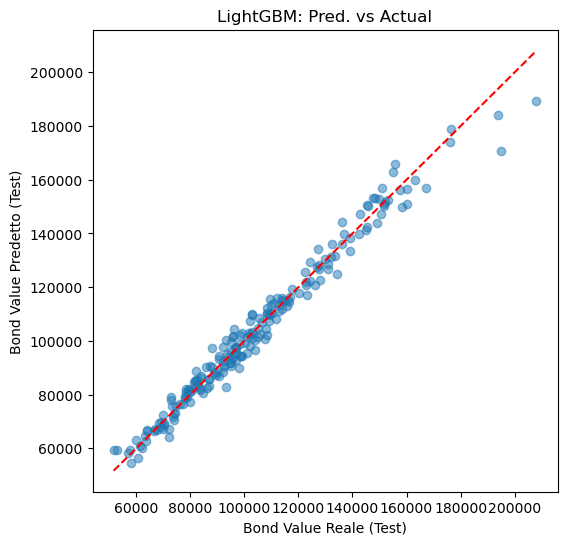


Esempio prime 5 righe con predicted_bond_value (LightGBM):
  credit_rating  debt_to_equity  energy_capacity         region  esg_rating  \
0            BB        0.925015        49.981000         Europe   20.775856   
1            AA        2.404028        29.555073  North America   90.184009   
2           BBB        2.008619         9.684890  North America   94.957444   
3           AAA        2.789894        20.601847         Europe   78.535606   
4           CCC        0.448415        32.440513         Europe    4.152142   

   predicted_bond_value  
0         153025.377868  
1         111997.954769  
2         135474.859862  
3          97118.529098  
4          95521.915241  


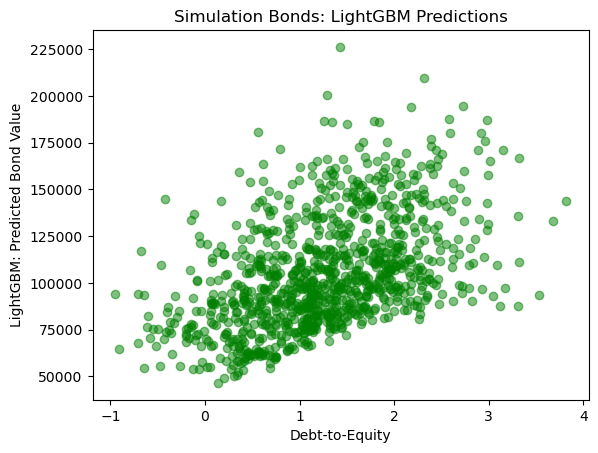

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Per LightGBM
from lightgbm import LGBMRegressor

# Preprocessing e valutazione
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score

# ======================================
# 1) CARICAMENTO DATASET STORICO
# ======================================
df_hist = pd.read_csv("/Users/tommasomarrucci/Documents/GitHub/YALE/historical_bonds.csv")

r = 0.05
df_hist['bond_value'] = (
    df_hist['cash_flow_1'] / (1 + r) +
    df_hist['cash_flow_2'] / (1 + r)**2 +
    df_hist['cash_flow_3'] / (1 + r)**3
)

# ======================================
# 2) FEATURES E TARGET
# ======================================
features = ['credit_rating', 'debt_to_equity', 'energy_capacity', 'region', 'esg_rating']
X = df_hist[features]
y = df_hist['bond_value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing
numeric_features = ['debt_to_equity', 'energy_capacity', 'esg_rating']
categorical_features = ['credit_rating', 'region']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# ======================================
# 3) MODELLO LIGHTGBM + GRID SEARCH
# ======================================
lgbm_reg = LGBMRegressor(random_state=42)

param_grid_lgb = {
    'n_estimators': [100, 300],
    'max_depth': [3, 6],
    'learning_rate': [0.1, 0.05],
    'subsample': [0.8, 1.0]
}

lgbm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search', GridSearchCV(
        lgbm_reg,
        param_grid_lgb,
        scoring='r2',
        cv=5,
        n_jobs=-1
    ))
])

# 4) FIT
lgbm_pipeline.fit(X_train, y_train)

lgbm_gs = lgbm_pipeline.named_steps['grid_search']
best_lgbm_model = lgbm_gs.best_estimator_

print("=== LightGBM ===")
print("Migliori parametri trovati:", lgbm_gs.best_params_)

# 5) VALUTAZIONE
y_pred_test = lgbm_pipeline.predict(X_test)
r2_lgb = r2_score(y_test, y_pred_test)
mae_lgb = mean_absolute_error(y_test, y_pred_test)

print(f"R^2 (Test) = {r2_lgb:.4f}")
print(f"MAE (Test) = {mae_lgb:.4f}")

# Plot
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')
plt.xlabel("Bond Value Reale (Test)")
plt.ylabel("Bond Value Predetto (Test)")
plt.title("LightGBM: Pred. vs Actual")
plt.show()

# ======================================
# 6) APPLICAZIONE SU SIMULATION_BONDS
# ======================================
df_sim = pd.read_csv("/Users/tommasomarrucci/Documents/GitHub/YALE/simulation_bonds.csv")

df_sim['predicted_bond_value'] = lgbm_pipeline.predict(df_sim[features])

print("\nEsempio prime 5 righe con predicted_bond_value (LightGBM):")
print(df_sim[['credit_rating','debt_to_equity','energy_capacity','region',
              'esg_rating','predicted_bond_value']].head())

# Salva su CSV
df_sim.to_csv("simulation_bonds_LGBM_pred.csv", index=False)

plt.figure()
plt.scatter(df_sim['debt_to_equity'], df_sim['predicted_bond_value'], alpha=0.5, color='green')
plt.xlabel("Debt-to-Equity")
plt.ylabel("LightGBM: Predicted Bond Value")
plt.title("Simulation Bonds: LightGBM Predictions")
plt.show()